# Imports

In [36]:
import os
os.chdir('../quafing/')
print(os.getcwd())

import quafing as q

from collections import Counter
from numpy import linalg as la
import numpy as np

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.manifold import TSNE

from itertools import product
from scipy.linalg import eigh

import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(12, 8)})

/Users/charlesdupont/Desktop/Thesis/code/quafing


# Helper Functions

In [4]:
def compute_embedding_variance(embedding):
    """
    Computes the variance of the embedding along the two dimensions.
    Args:
        embedding: numpy array with shape (num_samples, 2)
    Returns:
        array containing the variance along each dimension
    """
    return np.var(embedding, axis=0)


## Cluster validity measures
def cohesion(clusters):
    """
    Computes how close points in each cluster are to their cluster mean.
    We want to minimize this!
    """
    total = 0
    for c in clusters:
        mean = np.mean(c, axis=0)
        total += np.sum(np.linalg.norm(c-mean, axis=1))
    return total


def separation(clusters):
    """
    Computes how far the mean of each cluster is from the mean of cluster means.
    We want to maximize this!
    """
    means = [np.mean(c, axis=0) for c in clusters]
    mean_of_means = np.mean(means)
    total = 0
    for i, c in enumerate(clusters):
        total += len(c)*np.linalg.norm(means[i]-mean_of_means, axis=0)
    return total

# Part 1: Loading and preprocessing data

In [5]:
filepath = "../notebooks/data/omri_subak_data.xlsx"

In [6]:
rawmetadata, rawdata = q.load(filepath)
rawdata.head()

,Name of Subak,Number of farmers,Ownership,sharecrop,inherited,purchased,sold,income from sawah,harvest kg/ha,satisfaction,...,organization of collective work,reading and following written rules,fines frequency,condition of subak,subal meeting effectiveness,frequency of tehcnical problems,frequency of social problems,caste conflicts effects,class effect,"resilience, capability to overcome difficulties"
0,TAMPUAGAN HILIR,95,0.35,0.0,0,1,0,0.25,200,2,...,1,1,0.9,4,3,2,3,3,3,2
1,TAMPUAGAN HILIR,95,0.60,0.0,1,0,0,0.50,250,2,...,1,1,0.9,4,3,3,3,3,3,3
2,TAMPUAGAN HILIR,95,0.60,0.0,1,0,1,1.00,210,3,...,1,1,0.9,5,3,2,3,3,3,2
3,TAMPUAGAN HILIR,95,0.25,0.0,1,0,0,0.25,200,2,...,1,1,0.9,4,2,3,2,3,3,2
4,TAMPUAGAN HILIR,95,0.30,0.0,1,0,0,0.50,200,3,...,1,1,0.9,5,3,2,3,3,3,3


### Preproccessing

In [7]:
prep = q.PreProcessor(rawdata, rawmetadata)

We start by selecting the columns to be analyzed. Below, we create a selection, by deselecting all columns with type 'e'. However, direct selections by type or column name, or index are also possible. 

In [8]:
prep.select_columns(cols=['e'], deselect=True)

Next, we specify which columns contain continuous an discrete data, respectively. Quafing maintains an inner represenation of this distinction, thus supporting user defined column type schemes via this method. 
The default values, however, correspond to the standard defiined above.

In [9]:
prep.set_cont_disc()

With the data columns selected and the type of data specified, the penultimate preprocessing step is defining which density estimation methods are to be used in constructing the pdfs for each variable. This, again, can be done by column type, column name, or column index.

In our example all columns contain discrete data and the answers/variables are assume to be independent. Accoordingly, for each column (selected by type) a discrete 1d pdf will be estimated. 

In [10]:
prep.set_density_method(method='Discrete1D', cols=['o','u','b'])

Finally, the data is split into groups. This is based on grouping information supplied by the user (e.g. the column of type `g` in the standard format). To avoid ambiguity or mismatches with user defined type schemes, quaafing supports selection of the column to group by by column name or index only.
Here we are grouping and spliting based on the column with index 0

In [11]:
prep.split_to_groups(0)

### A collection of multi-dimensional pdfs

Having preprocessed and split the data, we can create a collection of multi-dimensional pdfs -- one for each group. As the answers for each question are assumed to be independent the full joint multidimensional pdf factorizes and we can create a factorized multi-dimensional pddf for each group, combinig them into a collection. `quafing` provides a convenience function for this operation.


In [12]:
mdpdfcol = q.create_mdpdf_collection('factorized', prep._groups, prep._grouplabels, prep._groupcolmetadata, )

Having created the collection we can calculate the Fisher information matrix, i.e. the matrix of pairwise FI distances.
Several possible algorithmic approximations of the FI distance are supported (here we use the hellinger distance). Distances are computed for each constituent pdf of the factorized multi-dimensional pdfs, and aggregated to combined distance using their root mean square.

In [13]:
mdpdfcol.calculate_distance_matrix(method='hellinger', pwdist='rms')

In [14]:
DATA = prep._data

# Part 2: T-SNE

### Hellinger distance on SM

In [444]:
distance_matrix = mdpdfcol.calculate_distance_matrix(method='hellinger', pwdist='rms', return_result=True)

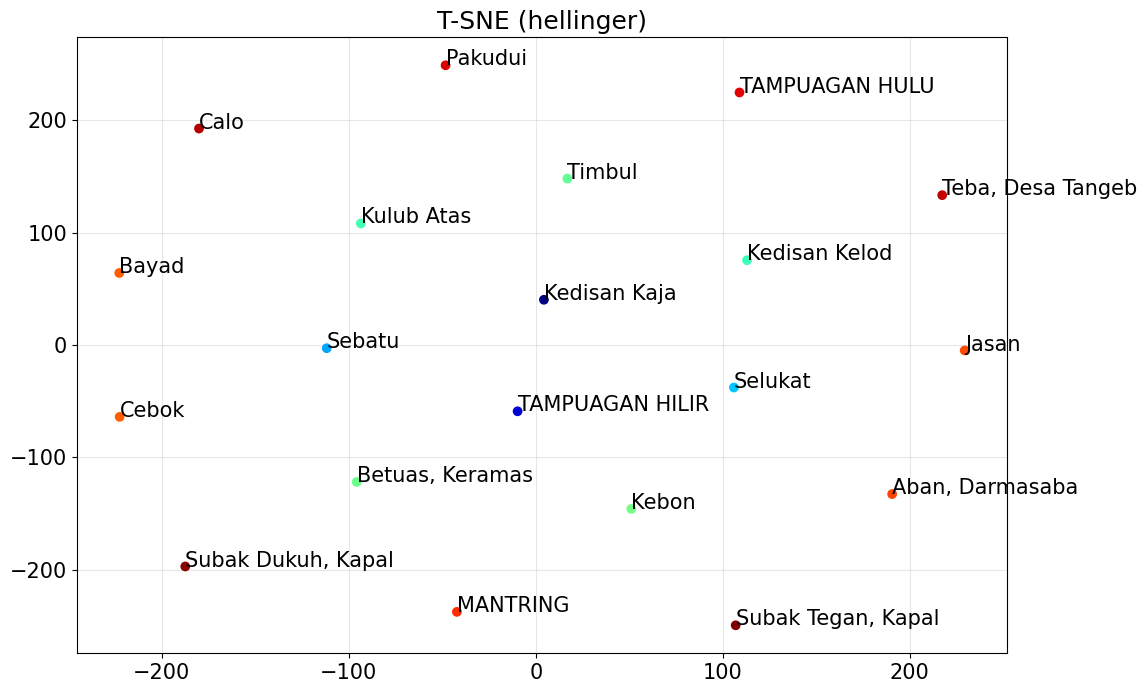

In [445]:
tsne_embedding = TSNE(n_components=2, metric="precomputed").fit_transform(distance_matrix)
q.plot_embedding({"embedding":tsne_embedding, "auxinfo":{"embedding_method":"T-SNE", "dimension":2}}, mdpdfcol)

### Embedding raw data

In [31]:
def tsne_parameter_sweep(X, d):
    print("Performing parameter sweep...")
    # parameter grid
    perplexity_values    = [10, 20, 50, 100, 200, 400]
    learning_rate_values = [10, 20, 50, 100, 175, 250]
    metrics              = ["euclidean", "cosine"]

    parameter_combinations = list(product(perplexity_values, learning_rate_values, metrics))
    tsne_embeddings = {}
    for c_idx, combination in enumerate(parameter_combinations):
        p, lr, m = combination
        tsne_embeddings[(p,lr,m)] = TSNE(n_components=d, init="pca", 
                                         perplexity=p, learning_rate=lr, metric=m).fit_transform(X)        
    return tsne_embeddings

In [84]:
def get_embedding(DATA, target_label, algorithm, d):
    X, y = get_dataset(DATA, target_label)
    
    if algorithm == "tsne":
        embeddings = tsne_parameter_sweep(X, d=d)
        title = "T-SNE"
    elif algorithm == "dmap":
        embeddings = dmap_parameter_sweep(X, d=d)
        title = "Diffusion Maps"
    else:
        print(f"Algorithm '{algorithm}' not implemented.")
        return
    
    if target_label:
        best_emb, best_params, best_performance = find_best_embedding(embeddings, y)
        plot_best_embedding(best_emb, y, title + f" ({target_label})", d)
    else:
        best_emb, best_params, best_performance = find_best_embedding_no_target(embeddings)
        plot_best_embedding_no_target(best_emb, title, d)
    
    return (X, y, best_emb, best_params, best_performance)


def get_dataset(X, target_label):
    print("Constructing dataset...")

    if target_label:
        y = np.array(X[target_label])
        X = X.loc[:, X.columns!=target_label]
    else:
        y = None
        
    enc = OneHotEncoder(drop="if_binary")
    enc.fit(X)
    X = enc.transform(X).toarray()
    return X, y


def find_best_embedding(embeddings, y):
    print("Finding best embedding...")
    best_emb = None
    best_params = None
    best_performance = -10
    
    for param_comb, embedding in embeddings.items():
        silhouette = silhouette_score(X=embedding, labels=y)
        if silhouette > best_performance:
            best_performance = silhouette
            best_emb = embedding
            best_params = param_comb
    
    return best_emb, best_params, best_performance


def find_best_embedding_no_target(embeddings):
    print("Finding best embedding without target...")
    best_emb = None
    best_params = None
    best_performance = -10
    
    for param_comb, embedding in embeddings.items():
        var = np.mean(np.var(embedding, axis=0))
        if var > best_performance:
            best_performance = var
            best_emb = embedding
            best_params = param_comb
    
    return best_emb, best_params, best_performance


def plot_best_embedding(best_emb, y, title, d):
    groups = {}
    for idx, row in enumerate(best_emb):
        label = y[idx]
        if label not in groups:
            groups[label] = [row]
        else:
            groups[label].append(row)
            
    if d == 2:
        for g, rows in groups.items():
            stacked = np.vstack(rows)
            plt.scatter(stacked[:,0], stacked[:,1], s=5, label=g)
    elif d == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for g, rows in groups.items():
            stacked = np.vstack(rows)
            ax.scatter(stacked[:,0], stacked[:,1], stacked[:,2], s=5, label=g)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(title)
    plt.show()
    

def plot_best_embedding_no_target(best_emb, title, d):
    if d == 2:
        plt.scatter(best_emb[:,0], best_emb[:,1], s=5)
    elif d == 3:
        ax.scatter(best_emb[:,0], best_emb[:,1], best_emb[:,2], s=5)
    plt.title(title)
    plt.show()

Constructing dataset...
Performing parameter sweep...
Finding best embedding...


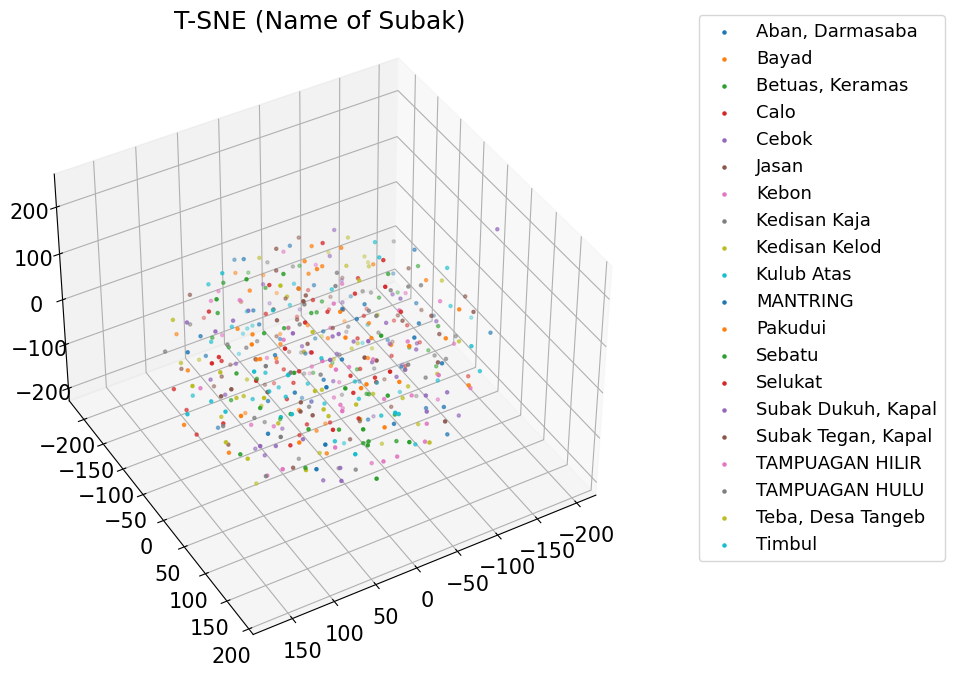


Best variance = -0.119

Best parameters:
perplexity    = 100
learning rate = 250
metric        = euclidean


In [88]:
# with target
T = "Name of Subak"
X, y, best_emb, best_params, best_performance = get_embedding(DATA, target_label=T, algorithm="tsne", d=3)

print(f"\nBest variance = {best_performance:.3f}")
print("\nBest parameters:")
print(f"perplexity    = {best_params[0]}")
print(f"learning rate = {best_params[1]}")
print(f"metric        = {best_params[2]}")

In [ ]:
# no target
best_emb, best_params, best_performance = get_embedding(DATA, target_label=None, algorithm="tsne", d=2)

print(f"\nBest variance = {best_performance:.3f}")
print("\nBest parameters:")
print(f"perplexity    = {best_params[0]}")
print(f"learning rate = {best_params[1]}")
print(f"metric        = {best_params[2]}")

# Part 3: Diffusion Maps

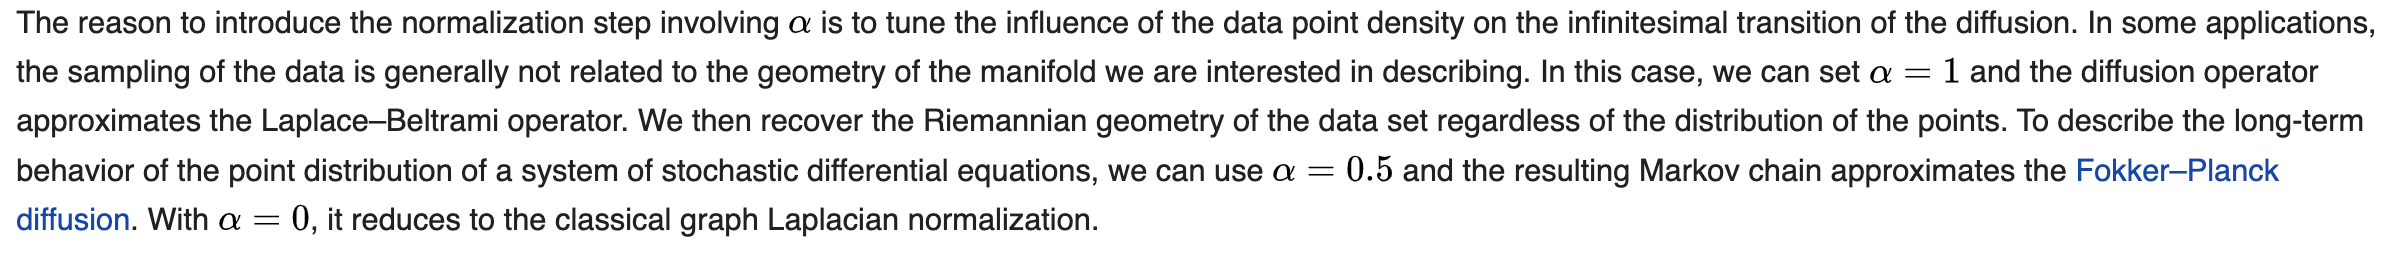

In [56]:
# code is adapted from:
# https://github.com/arashbehboodi/DiffusionMap


def diffusionmap(data_matrix, distance_mat, n, eps, t, n_eigen):
    """
    distance_mat: distance matrix
    t: t indicates the number of iterations.
    n_eigen: indicates the target dimension for dimensionality reduction
    eps: is the parameter of Guassian kernel that is used.
    """    
    
    if data_matrix is not None and distance_mat is None:
        distance_mat = euclidean_distances(data_matrix, data_matrix)

    # Kernel function for weight matrx: Gaussian Kernel
    # Constructing the weight matrix
    W = np.exp(-distance_mat/eps)
    
    # Degree matrix
    Deg = W@np.ones((n, 1))
    D = np.diag(Deg.reshape(n,))
    
    # Transition matrix
    M = la.inv(D)@W
    
    # Constructing the matrix S - obtaining diffusion vectors
    S = D**(1/2)@M@la.inv(D)**(1/2)
    
    # Spectral decomposition
    eigvalCov, eigvecCov = la.eig(S)
    idx = eigvalCov.argsort()[::-1]
    eigvalCov = eigvalCov[idx]
    eigvecCov = eigvecCov[:, idx]
    
    # Diffusion Map
    phiD = la.inv(D)**(1/2)@eigvecCov
    lambdaD = eigvalCov**t
    
    # Final Matrix with columns as the vectors
    DiffM = np.diag(lambdaD)@phiD.T
    Difftruncated = DiffM[1:n_eigen+1, :]
    return Difftruncated.T

### Using pdf distance matrix

In [ ]:
best_var = -1
best_params = None

for eps in np.linspace(0.01, 0.99, 20):
    results[eps] = {}
    for t in [0, 0.5, 1]:
        temp = diffusionmap(distance_matrix, len(distance_matrix), eps=eps, t=t, n_eigen=2)
        var = compute_embedding_variance(temp)
        if sum(var) > best_var:
            best_var = sum(var)
            best_params = (eps,t)
            
print(best_params, best_var)

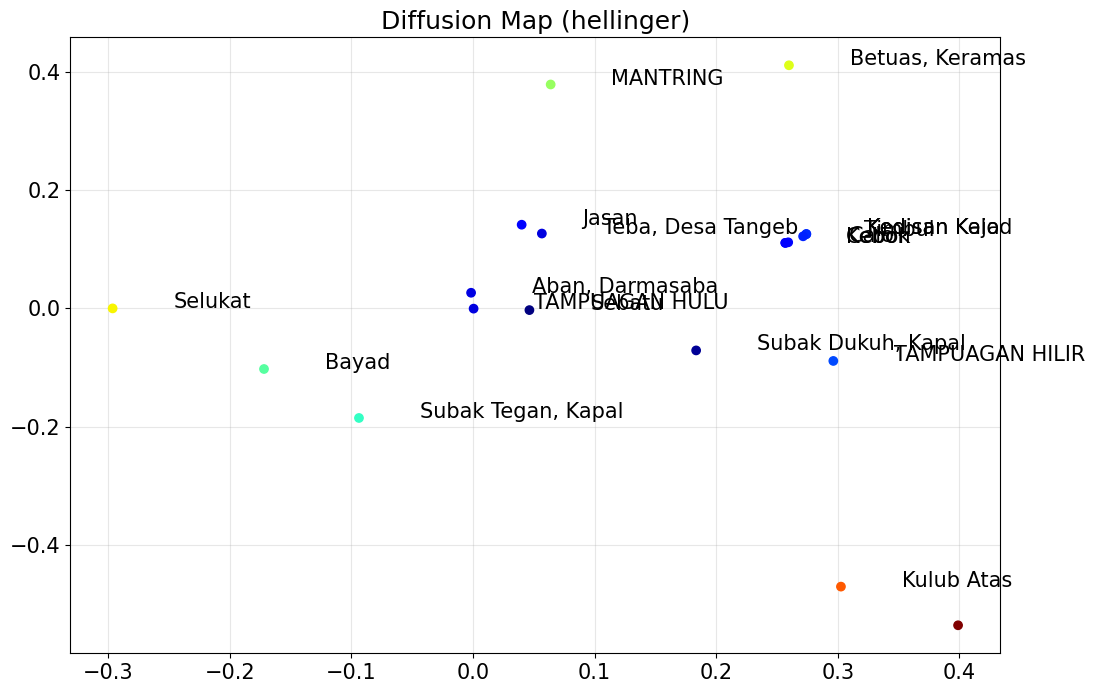

Diffusion map embedding variance
x: 0.05
y: 0.04


In [275]:
dmap_embedding = diffusionmap(distance_matrix, len(distance_matrix), eps=0.09, t=1, n_eigen=2)
q.plot_embedding({"embedding":dmap_embedding, 
                  "auxinfo":{"embedding_method":"Diffusion Map", "dimension":2}}, mdpdfcol)

### Embedding raw data

In [57]:
def dmap_parameter_sweep(X, d):
    print("Performing parameter sweep...")
    
    # parameter grid
    epsilon_values = np.linspace(0.01, 5, 20)
    t_values       = [0, 0.5, 1.0]

    parameter_combinations = list(product(epsilon_values, t_values))
    dmap_embeddings = {}
    for combination in parameter_combinations:
        eps, t = combination
        dmap_embeddings[(eps, t)] = np.real(diffusionmap(data_matrix=X, distance_mat=None, 
                                                         n=len(X), eps=eps, t=t, n_eigen=d))
    return dmap_embeddings

Constructing dataset...
Performing parameter sweep...


<ipython-input-56-6fba310b9c3f>:38: RuntimeWarning: invalid value encountered in sqrt
  lambdaD = eigvalCov**t
<ipython-input-56-6fba310b9c3f>:38: RuntimeWarning: invalid value encountered in sqrt
  lambdaD = eigvalCov**t
<ipython-input-56-6fba310b9c3f>:38: RuntimeWarning: invalid value encountered in sqrt
  lambdaD = eigvalCov**t
<ipython-input-56-6fba310b9c3f>:38: RuntimeWarning: invalid value encountered in sqrt
  lambdaD = eigvalCov**t
<ipython-input-56-6fba310b9c3f>:38: RuntimeWarning: invalid value encountered in sqrt
  lambdaD = eigvalCov**t
<ipython-input-56-6fba310b9c3f>:38: RuntimeWarning: invalid value encountered in sqrt
  lambdaD = eigvalCov**t


Finding best embedding...


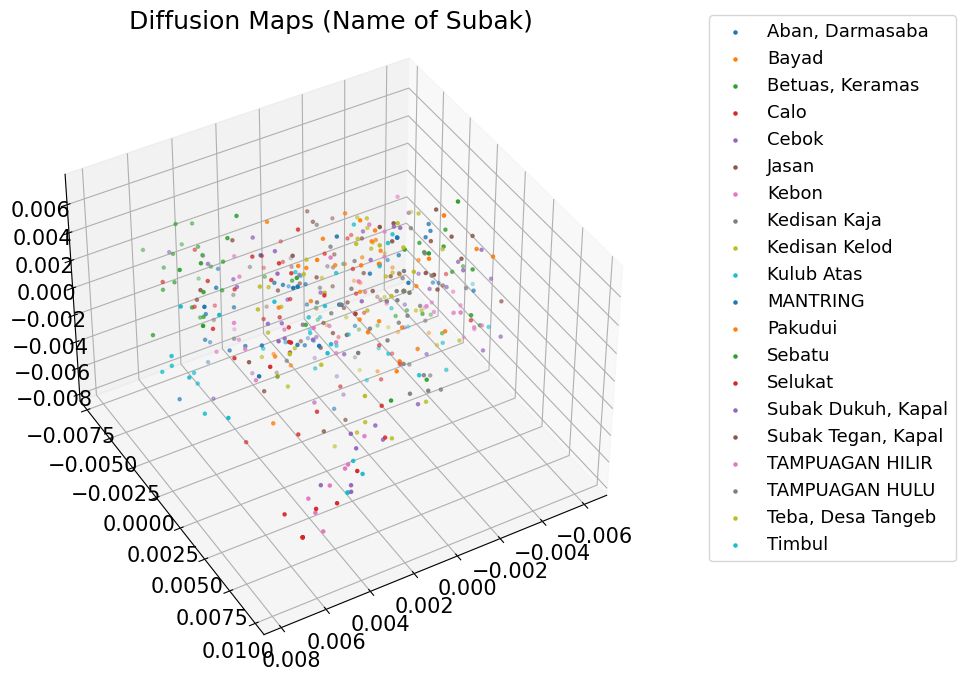


Best (mean) silhouette score = -0.146

Best parameters:
epsilon = 5.00
t       = 0


In [91]:
# with target
T = "Name of Subak"
X, y, best_emb, best_params, best_performance = get_embedding(DATA, target_label=T, algorithm="dmap", d=3)

print(f"\nBest (mean) silhouette score = {best_performance:.3f}")
print("\nBest parameters:")
print(f"epsilon = {best_params[0]:.2f}")
print(f"t       = {best_params[1]}")

In [ ]:
# no target
X, y, best_emb, best_params, best_performance = get_embedding(DATA, target_label=None, 
                                                              algorithm="dmap", d=3)
print(f"\nBest (mean) silhouette score = {best_performance:.3f}")
print("\nBest parameters:")
print(f"epsilon = {best_params[0]:.2f}")
print(f"t       = {best_params[1]}")

# Part 4: Quafing

Given the distance matrix it is straight forward to determine the shortest path matrix

In [27]:
mdpdfcol.calculate_shortest_path_matrix()

### Embedding

Given N questions on the questionaire, the FI distances and shortest paths lie and are defined on the N-1 dimensional hypershere, making investiagting/understanding the structure of the data difficult. To this end the collection can be embedded in a lower dimensional space usingg the previously calculated information distances.

`quafing` provides an `Embedder` class, with support for a range oof embeddingg algorithms (mds, further options under development)

In [28]:
embedder = q.get_embedder('mds', mdpdfcol)

For example the multi-dimenssional pdf collection can be embedded in 2 dimensions

In [29]:
quafing_embedding = embedder.embed(dimension=2, return_all=True)

an embeding consists of the actual embedding and a dictionary with relevant data about the settings used. It is up to the user to ensure that data/multi-dimensional pdf collection and embedding stay together

Specifically for the MDS embedder evaluating the stress of the embedding as a function of its dimensionality (with graphical representation) is supported  

In [30]:
# embedder.eval_stress_v_dimension(plot=True)

### Visualization

Finally, for embeddings in 2 or 3 dimensions, `quafing` also provides a convenience function for visualizing the embedding, which takes the calculated embedding and the multi-dimensional pdf collection object as inputs

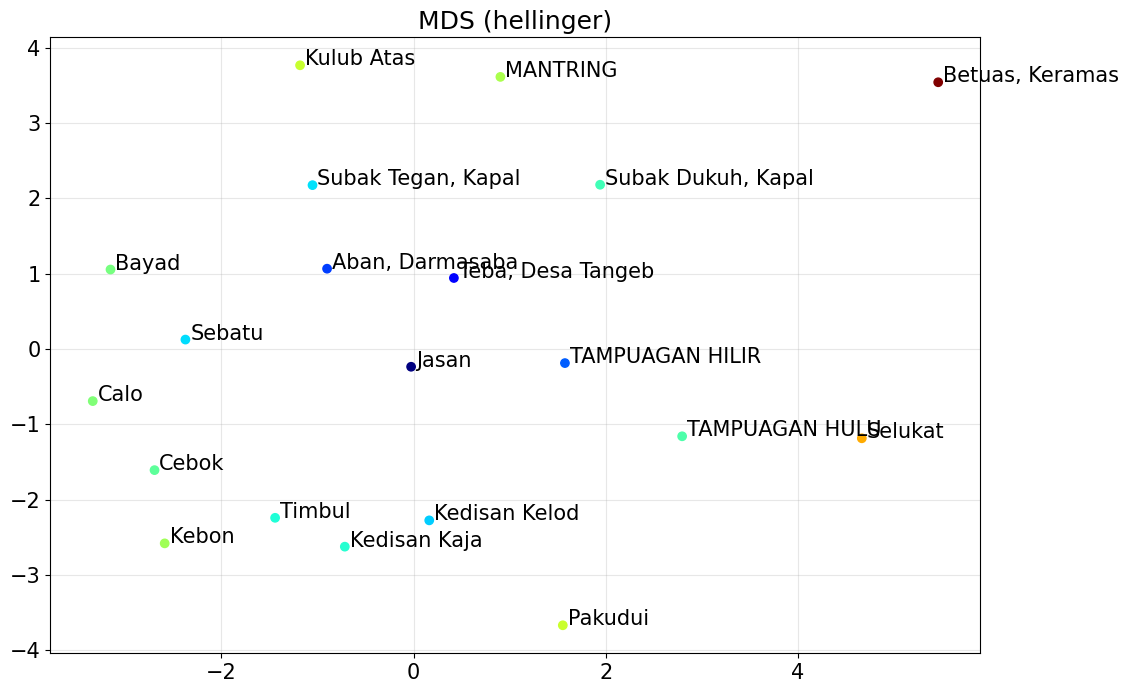

Quafing embedding variance
x: 5.78
y: 4.77


In [33]:
q.plot_embedding(quafing_embedding, mdpdfcol)